<a href="https://colab.research.google.com/github/shailendrapr/Sentiment-Voice-Analysis/blob/main/Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install librosa

In [3]:
import librosa
from librosa import display

data, sampling_rate = librosa.load('/content/Emotion-Classification-Ravdess/Ravtess/Actor_01/03-01-01-01-02-01-01.wav')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


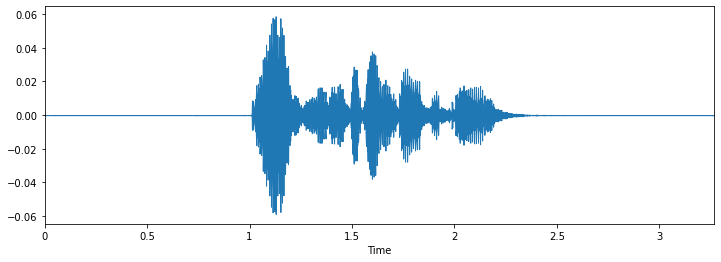

In [4]:
% pylab inline
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

In [6]:
import time
import os
path = '/content/Emotion-Classification-Ravdess/Ravtess'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 311.57203555107117 seconds ---


In [7]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [8]:
import numpy as np
X = np.asarray(X)
y = np.asarray(y)


X.shape, y.shape

((5252, 40), (5252,))

In [10]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/Emotion-Classification-Ravdess/Ravtess_model'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [12]:
import joblib
X = joblib.load('/content/Emotion-Classification-Ravdess/Ravtess_model/X.joblib')
y = joblib.load('/content/Emotion-Classification-Ravdess/Ravtess_model/y.joblib')

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.33, random_state=42)

In [14]:
from sklearn.tree import DecisionTreeClassifier

In [15]:
dtree = DecisionTreeClassifier()

In [16]:
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [17]:
predictions = dtree.predict(X_test)

In [18]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.78      0.81      0.79       200
           1       0.59      0.50      0.54       144
           2       0.61      0.62      0.62       250
           3       0.69      0.64      0.67       249
           4       0.69      0.73      0.71       235
           5       0.63      0.72      0.67       252
           6       0.70      0.65      0.67       200
           7       0.67      0.64      0.66       204

    accuracy                           0.67      1734
   macro avg       0.67      0.66      0.67      1734
weighted avg       0.67      0.67      0.67      1734



In [19]:
import numpy as np
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [20]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

In [25]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

model = Sequential()

model.add(Conv1D(64, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(4)))
model.add(Conv1D(256, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, epsilon=1e-07, decay=0.0)

In [26]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 40, 64)            384       
                                                                 
 activation_12 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_9 (Dropout)         (None, 40, 64)            0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 128)           41088     
                                                                 
 activation_13 (Activation)  (None, 10, 128)           0         
                                                      

In [27]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [28]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
220/220 [==============================] - 9s 32ms/step - loss: 4.3104 - accuracy: 0.1728 - val_loss: 1.8011 - val_accuracy: 0.3766
Epoch 2/200
220/220 [==============================] - 4s 16ms/step - loss: 2.5519 - accuracy: 0.2888 - val_loss: 1.5019 - val_accuracy: 0.4960
Epoch 3/200
220/220 [==============================] - 3s 16ms/step - loss: 1.9512 - accuracy: 0.3846 - val_loss: 1.4028 - val_accuracy: 0.5063
Epoch 4/200
220/220 [==============================] - 3s 15ms/step - loss: 1.6555 - accuracy: 0.4466 - val_loss: 1.3071 - val_accuracy: 0.5565
Epoch 5/200
220/220 [==============================] - 4s 16ms/step - loss: 1.4910 - accuracy: 0.4955 - val_loss: 1.2242 - val_accuracy: 0.5882
Epoch 6/200
220/220 [==============================] - 3s 16ms/step - loss: 1.3724 - accuracy: 0.5347 - val_loss: 1.1217 - val_accuracy: 0.6153
Epoch 7/200
220/220 [==============================] - 4s 16ms/step - loss: 1.2668 - accuracy: 0.5617 - val_loss: 1.0815 - val_accuracy:

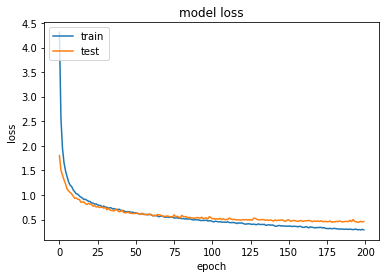

In [29]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

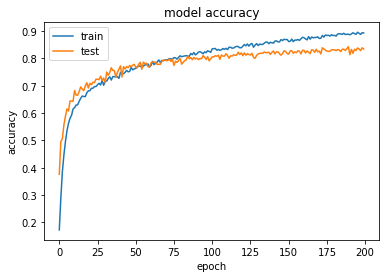

In [30]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [47]:
#predict_x=model.predict(x_testcnn) 
#classes_x=np.argmax(predict_x,axis=1)

In [41]:
#size(predictions)

13872

In [53]:
predictions = np.argmax(model.predict(x_testcnn),axis=1)

In [54]:
predictions

array([2, 6, 5, ..., 2, 6, 5])

In [49]:
y_test

array([2, 6, 5, ..., 2, 6, 5])

In [50]:
new_Ytest = y_test.astype(int)

In [51]:
new_Ytest

array([2, 6, 5, ..., 2, 6, 5])

In [55]:
from sklearn.metrics import classification_report
report = classification_report(new_Ytest, predictions)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       200
           1       0.79      0.69      0.74       144
           2       0.88      0.81      0.85       250
           3       0.82      0.79      0.80       249
           4       0.88      0.91      0.90       235
           5       0.78      0.86      0.82       252
           6       0.73      0.90      0.80       200
           7       0.93      0.79      0.85       204

    accuracy                           0.83      1734
   macro avg       0.84      0.83      0.83      1734
weighted avg       0.84      0.83      0.83      1734



In [56]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(new_Ytest, predictions)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[176   9   0   9   0   1   2   3]
 [  9 100  13   8   0   4  10   0]
 [  1   5 203   3   8  14  12   4]
 [  4   8   2 196   3  24  10   2]
 [  0   1   3   1 215   6   9   0]
 [  0   2   2  14   8 217   9   0]
 [  3   0   2   2   3   7 179   4]
 [  3   1   5   7   7   5  15 161]]


In [57]:
model.save('testing10_model.h5')
print("MODEL SAVED")

MODEL SAVED


In [58]:
new_model=keras.models.load_model('testing10_model.h5')
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 40, 64)            384       
                                                                 
 activation_12 (Activation)  (None, 40, 64)            0         
                                                                 
 dropout_9 (Dropout)         (None, 40, 64)            0         
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 10, 64)           0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 10, 128)           41088     
                                                                 
 activation_13 (Activation)  (None, 10, 128)           0         
                                                      

In [59]:
loss, acc = new_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

55/55 [==============================] - 0s 4ms/step - loss: 0.4591 - accuracy: 0.8345
Restored model, accuracy: 83.45%
